# Text classification

### import libs and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, Dropout, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange
print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.8.2


### Load data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data = data.drop(columns=['url', 'title', 'tags', 'date'])

In [ ]:
data.shape

(800975, 2)

In [ ]:
#data = data[:500000]

In [ ]:
# Drop rows with missing topics and texts
data.dropna(subset=['topic'], inplace=True)
data.dropna(subset=['text'], inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data

,text,topic
0,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека
1,"Министерство народного просвещения, в виду про...",Библиотека
2,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека
3,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека
4,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека
...,...,...
739171,Протесты движения «желтых жилетов» в Париже сн...,Мир
739172,Истребитель Су-27 разбился в Житомирской облас...,Бывший СССР
739173,В Московском районе Санкт-Петербурга на продаж...,Дом
739174,Швейцарский горнолыжник Марк Гизин неудачно пр...,Спорт


### Выборка данных


In [ ]:
print(data['topic'].unique(), len(data['topic'].unique()))

['Библиотека' 'Россия' 'Мир' 'Экономика' 'Интернет и СМИ' 'Спорт'
 'Культура' 'Из жизни' 'Силовые структуры' 'Наука и техника' 'Бывший СССР'
 'Дом' 'Сочи' 'ЧМ-2014' 'Путешествия' 'Ценности' 'Легпром' 'Бизнес'
 'МедНовости' 'Оружие' '69-я параллель' 'Культпросвет ' 'Крым'] 23


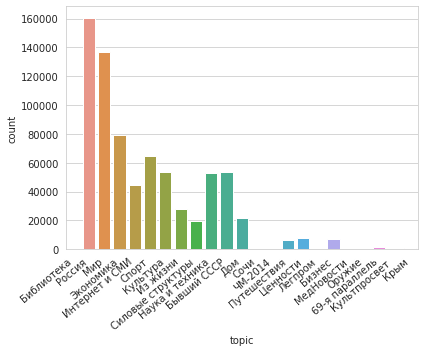

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='topic', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [ ]:
topics = ['Россия', 'Мир', 'Экономика', 'Интернет и СМИ', 'Спорт', 'Культура', 
          'Из жизни', 'Силовые структуры', 'Наука и техника', 'Бывший СССР']

In [ ]:
data.shape

(738968, 2)

In [ ]:
c = dict.fromkeys(topics, 0)
for i in topics:
  for j in data['topic']:
    if j == i:
      c[i] += 1
print(c)

{'Россия': 160442, 'Мир': 136620, 'Экономика': 79528, 'Интернет и СМИ': 44663, 'Спорт': 64413, 'Культура': 53796, 'Из жизни': 27605, 'Силовые структуры': 19596, 'Наука и техника': 53136, 'Бывший СССР': 53402}


In [ ]:
news_in_cat_count = 19000

In [ ]:
df_res = pd.DataFrame()

for topic in tqdm(topics):
    df_topic = data[data['topic'] == topic][:news_in_cat_count]
    df_res = df_res.append(df_topic, ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
df_res.shape

(190000, 2)

In [ ]:
df_res.head()

,text,topic
0,Как стало известно агентству Ассошиэйтед Пресс...,Россия
1,В зале игровых автоматов в третьем ярусе подзе...,Россия
2,Япония приняла решение разморозить кредиты Рос...,Россия
3,В понедельник директор департамента внешних св...,Россия
4,С 1 сентября на всей территории России вводитс...,Россия


### Предобработка данных

In [ ]:
import string
from nltk.stem import *
from string import punctuation
from nltk import word_tokenize

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)

In [ ]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df_res['text']]

In [ ]:
df_res['text_prep'] = prep_text

Stopwords

In [ ]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д'])

In [ ]:

sw_texts_list = []
for text in tqdm(df_res['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_res['text_sw'] = sw_texts_list


  0%|          | 0/190000 [00:00<?, ?it/s]

In [ ]:
df_res.replace('', np.nan, inplace=True)
df_res.dropna(axis=0,inplace=True)

In [ ]:
df_res.to_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-sw.csv', index=False)

In [ ]:
df_res = pd.read_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-sw.csv')

In [ ]:
df_res.head()

,text,topic,text_prep,text_sw
0,Как стало известно агентству Ассошиэйтед Пресс...,Россия,как стало известно агентству ассошиэйтед пресс...,стало известно агентству ассошиэйтед пресс эки...
1,В зале игровых автоматов в третьем ярусе подзе...,Россия,в зале игровых автоматов в третьем ярусе подзе...,зале игровых автоматов третьем ярусе подземног...
2,Япония приняла решение разморозить кредиты Рос...,Россия,япония приняла решение разморозить кредиты рос...,япония приняла решение разморозить кредиты рос...
3,В понедельник директор департамента внешних св...,Россия,в понедельник директор департамента внешних св...,понедельник директор департамента внешних связ...
4,С 1 сентября на всей территории России вводитс...,Россия,с сентября на всей территории россии вводится ...,сентября всей территории россии вводится новая...


In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189999 entries, 0 to 189999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       189999 non-null  object
 1   topic      189999 non-null  object
 2   text_prep  189999 non-null  object
 3   text_sw    189999 non-null  object
dtypes: object(4)
memory usage: 7.2+ MB


Стемминг

In [ ]:

from nltk.stem.snowball import SnowballStemmer 

stemmer = SnowballStemmer("russian")
stemmed_texts_list = []
for text in tqdm(df_res['text_sw']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df_res['text_stem'] = stemmed_texts_list


  0%|          | 0/189999 [00:00<?, ?it/s]

In [ ]:
# Drop rows with missing topics and texts
df_res.dropna(subset=['topic'], inplace=True)
df_res.dropna(subset=['text_stem'], inplace=True)
df_res.replace('', np.nan, inplace=True)
df_res.dropna(axis=0,inplace=True)

In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189999 entries, 0 to 189999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       189999 non-null  object
 1   topic      189999 non-null  object
 2   text_prep  189999 non-null  object
 3   text_sw    189999 non-null  object
 4   text_stem  189999 non-null  object
dtypes: object(5)
memory usage: 8.7+ MB


In [ ]:
df_res.to_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-stem-sw.csv', index=False)

In [ ]:
df_res = pd.read_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-stem-sw.csv') ########################################################################

In [ ]:
df_res.head()

,text,topic,text_prep,text_sw,text_stem
0,Как стало известно агентству Ассошиэйтед Пресс...,Россия,как стало известно агентству ассошиэйтед пресс...,стало известно агентству ассошиэйтед пресс эки...,стал известн агентств ассошиэйтед пресс экипаж...
1,В зале игровых автоматов в третьем ярусе подзе...,Россия,в зале игровых автоматов в третьем ярусе подзе...,зале игровых автоматов третьем ярусе подземног...,зал игров автомат трет ярус подземн комплекс о...
2,Япония приняла решение разморозить кредиты Рос...,Россия,япония приняла решение разморозить кредиты рос...,япония приняла решение разморозить кредиты рос...,япон приня решен размороз кредит росс сумм пол...
3,В понедельник директор департамента внешних св...,Россия,в понедельник директор департамента внешних св...,понедельник директор департамента внешних связ...,понедельник директор департамент внешн связ ме...
4,С 1 сентября на всей территории России вводитс...,Россия,с сентября на всей территории россии вводится ...,сентября всей территории россии вводится новая...,сентябр все территор росс ввод нов форм таможе...


In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189999 entries, 0 to 189998
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       189999 non-null  object
 1   topic      189999 non-null  object
 2   text_prep  189999 non-null  object
 3   text_sw    189999 non-null  object
 4   text_stem  189999 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


Лемматизация

In [ ]:
from pymystem3 import Mystem
mystem = Mystem() 

lemm_texts_list = []
for text in tqdm(df_res['text_stem']):
    text_lem = mystem.lemmatize(text)
    tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
    text = " ".join(tokens)
    lemm_texts_list.append(text)

df_res['text_lemm'] = lemm_texts_list


In [ ]:
# Drop rows with missing topics and texts
df_res.dropna(subset=['topic'], inplace=True)
df_res.dropna(subset=['text_lemm'], inplace=True)
df_res.replace('', np.nan, inplace=True)
df_res.dropna(axis=0,inplace=True)

In [ ]:
df_res.info()

In [ ]:
df_res.to_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-lemm-stem-sw.csv', index=False)  # full ready data

In [ ]:
df_res = pd.read_csv('/content/drive/MyDrive/lenta_news/lenta-ru-news-lemm-stem-sw.csv')

In [ ]:
df_res.head()

,text,topic,text_prep,text_sw,text_stem
0,Как стало известно агентству Ассошиэйтед Пресс...,Россия,как стало известно агентству ассошиэйтед пресс...,стало известно агентству ассошиэйтед пресс эки...,стал известн агентств ассошиэйтед пресс экипаж...
1,В зале игровых автоматов в третьем ярусе подзе...,Россия,в зале игровых автоматов в третьем ярусе подзе...,зале игровых автоматов третьем ярусе подземног...,зал игров автомат трет ярус подземн комплекс о...
2,Япония приняла решение разморозить кредиты Рос...,Россия,япония приняла решение разморозить кредиты рос...,япония приняла решение разморозить кредиты рос...,япон приня решен размороз кредит росс сумм пол...
3,В понедельник директор департамента внешних св...,Россия,в понедельник директор департамента внешних св...,понедельник директор департамента внешних связ...,понедельник директор департамент внешн связ ме...
4,С 1 сентября на всей территории России вводитс...,Россия,с сентября на всей территории россии вводится ...,сентября всей территории россии вводится новая...,сентябр все территор росс ввод нов форм таможе...


In [ ]:
df_res.info()

### Split the data into training and test sets

In [ ]:
X = df_res['text_stem'].fillna("")
y = df_res['topic'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

In [ ]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(170999,) (19000,)
(170999,) (19000,)


### Vectorize the Text Corpus



1.   ***fit_on_texts*** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).
2.   ***texts_to_sequences*** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate


Set Hyperparameters

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 250000

# Dimension of the dense embedding.
embedding_dim = 300

# Max number of words in each complaint.
max_length = 500

In [ ]:
X_train

72816     социальн сет одноклассник сдела платн использо...
81869     победител лиг чемпион сезон стал португальск п...
163481    компан raytheon farnborough представ систем на...
139618    фотограф компонент устройств помощ котор взорв...
71919     компан googl сотруднича продавц программн обес...
                                ...                        
119879    эрик джонсон eric johnson летн гражданин сша м...
103694    правительств австрийск республик призна аккуму...
131932    западн сми сообщ беремен амал аламуддин невест...
146867    мещанск суд москв приговор двум год колон штра...
121958    британск военнослужа наход ночн патрул замет к...
Name: text_stem, Length: 170999, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

Found 243041 unique tokens.


{'<OOV>': 1,
 'год': 2,
 'заяв': 10,
 'компан': 9,
 'котор': 3,
 'росс': 6,
 'сво': 7,
 'сообща': 4,
 'такж': 8,
 'эт': 5}

In [ ]:
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, value=0.0,
                             padding='post', truncating='post')

validation_seq = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding='post', truncating='post')

print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (170999, 500)
Shape of data tensor: (19000, 500)


In [ ]:
import pickle

# saving
with open('/content/drive/MyDrive/tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### One Hot Encode the topics

In [ ]:
encode = OneHotEncoder()

training_labels = encode.fit_transform(y_train.reshape(-1, 1))
validation_labels = encode.transform(y_test.reshape(-1, 1))

In [ ]:
#encode.categories_

In [ ]:
#res = encode.inverse_transform(training_labels[112].reshape(1, -1))

### Check the same of the data

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))

(170999, 500)
(19000, 10)
(19000, 500)
(170999, 10)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
train_padded

array([[  740,   218,  5650, ...,     0,     0,     0],
       [  772,   796,   382, ...,     0,     0,     0],
       [    9,  8015, 35216, ...,     0,     0,     0],
       ...,
       [  647,   414,    27, ...,     0,     0,     0],
       [11356,    21,    44, ...,     0,     0,     0],
       [  222,   600,    57, ...,     0,     0,     0]], dtype=int32)

In [ ]:
#train_padded[0]

### Build the Model

In [ ]:
'''
embedding_dim = 300
labels_len = 10  # number of classes
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(32, 3, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(64, 3, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax'))

model.summary()
'''

'\nembedding_dim = 300\nlabels_len = 10  # number of classes\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))\n\nmodel.add(Conv1D(32, 3, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\n\nmodel.add(Conv1D(64, 3, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv1D(64, 3, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(128, activation=\'relu\'))\nmodel.add(Dropout(0.5))          \nmodel.add(Dense(labels_len, activation=\'softmax\'))\n\nmodel.summary()\n'

In [ ]:
'''
labels_len = 10  # number of classes

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.summary()
'''

"\nlabels_len = 10  # number of classes\n\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))\n\nmodel.add(Conv1D(48, 5, activation='relu', padding='valid'))\nmodel.add(GlobalMaxPooling1D())\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\nmodel.add(Dropout(0.5))\n\nmodel.add(Dense(10, activation='softmax'))\n\nmodel.summary()\n"

In [ ]:
'''
embedding_dim = 300
labels_len = 10  # number of classes
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
######model.add(Dropout(0.5))   #

model.add(Conv1D(16, 3, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(32, 3, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

######model.add(Dropout(0.5))   #

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax'))

model.summary()
'''

'\nembedding_dim = 300\nlabels_len = 10  # number of classes\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))\n######model.add(Dropout(0.5))   #\n\nmodel.add(Conv1D(16, 3, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv1D(32, 3, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\n######model.add(Dropout(0.5))   #\n\nmodel.add(Dense(128, activation=\'relu\'))\nmodel.add(Dropout(0.5))          \nmodel.add(Dense(labels_len, activation=\'softmax\'))\n\nmodel.summary()\n'

In [ ]:
'''
embedding_dim = 200
labels_len = 10  # number of classes
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
######model.add(Dropout(0.5))   #

model.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

######model.add(Dropout(0.5))   #

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax'))

model.summary()
'''

'\nembedding_dim = 200\nlabels_len = 10  # number of classes\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))\n######model.add(Dropout(0.5))   #\n\nmodel.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\n######model.add(Dropout(0.5))   #\n\nmodel.add(Dense(64, activation=\'relu\'))\nmodel.add(Dropout(0.5))          \nmodel.add(Dense(labels_len, activation=\'softmax\'))\n\nmodel.summary()\n'

In [ ]:
'''
embedding_dim = 200
labels_len = 10  # number of classes
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))
######model.add(Dropout(0.5))   #

model.add(Conv1D(8, 5, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

######model.add(Dropout(0.5))   #

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax'))

model.summary()
'''

'\nembedding_dim = 200\nlabels_len = 10  # number of classes\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))\n######model.add(Dropout(0.5))   #\n\nmodel.add(Conv1D(8, 5, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv1D(16, 5, padding="valid", activation="relu", strides=1))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Dropout(0.5))\n\nmodel.add(Flatten())\n\n######model.add(Dropout(0.5))   #\n\nmodel.add(Dense(32, activation=\'relu\'))\nmodel.add(Dropout(0.5))          \nmodel.add(Dense(labels_len, activation=\'softmax\'))\n\nmodel.summary()\n'

In [ ]:
'''
###################################################################################################################
from tensorflow.keras.regularizers import l2

Regularizer = l2(0.0001)

vocab_size = 250000
embedding_dim = 200
labels_len = 10  # number of classes

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                    input_length=train_padded.shape[1]))

model.add(Conv1D(16, 3, activation="relu", strides=1, 
                 kernel_regularizer=Regularizer,
                 bias_regularizer=Regularizer,
                 activity_regularizer=Regularizer
                 ))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(32, 3, activation="relu", strides=1, 
                 kernel_regularizer=Regularizer,
                 bias_regularizer=Regularizer,
                 activity_regularizer=Regularizer
                 ))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu',
                kernel_regularizer=Regularizer,
                bias_regularizer=Regularizer,
                activity_regularizer=Regularizer                
                ))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax',
                kernel_regularizer=Regularizer,
                bias_regularizer=Regularizer,
                activity_regularizer=Regularizer
                ))

model.summary()

########################################################################################################################
'''

In [ ]:
from tensorflow.keras.regularizers import l2

Regularizer = l2(0.0001)

vocab_size = 250000
embedding_dim = 200
labels_len = 10  # number of classes

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                    input_length=train_padded.shape[1]))

model.add(Conv1D(16, 3, activation="relu", strides=1, 
                 kernel_regularizer=Regularizer,
                 bias_regularizer=Regularizer,
                 activity_regularizer=Regularizer
                 ))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv1D(32, 3, activation="relu", strides=1, 
                 kernel_regularizer=Regularizer,
                 bias_regularizer=Regularizer,
                 activity_regularizer=Regularizer
                 ))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu',
                kernel_regularizer=Regularizer,
                bias_regularizer=Regularizer,
                activity_regularizer=Regularizer                
                ))
model.add(Dropout(0.5))          
model.add(Dense(labels_len, activation='softmax',
                kernel_regularizer=Regularizer,
                bias_regularizer=Regularizer,
                activity_regularizer=Regularizer
                ))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 200)          50000000  
                                                                 
 conv1d_8 (Conv1D)           (None, 498, 16)           9616      
                                                                 
 batch_normalization_8 (Batc  (None, 498, 16)          64        
 hNormalization)                                                 
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 249, 16)          0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 249, 16)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 247, 32)          

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
epochs = 300
batch_size = 128

In [ ]:
# Контрольная точка для сохранения модели с наилучшей производительностью на проверочном наборе
file_path = "/content/drive/MyDrive/best_model/model_best_val.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_model = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
early_loss = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
early_acc = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)

callback = [checkpoint, reduce_model, early_loss, early_acc]

In [ ]:
history = model.fit(train_padded, training_labels, shuffle=True,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.3,
                    callbacks=callback)

Epoch 1/300
935/936 [============================>.] - ETA: 0s - loss: 2.3267 - accuracy: 0.1271
Epoch 1: val_loss improved from inf to 2.08986, saving model to /content/drive/MyDrive/best_model/model_best_val.h5
936/936 [==============================] - 42s 44ms/step - loss: 2.3267 - accuracy: 0.1271 - val_loss: 2.0899 - val_accuracy: 0.1938 - lr: 0.0010
Epoch 2/300
935/936 [============================>.] - ETA: 0s - loss: 1.9297 - accuracy: 0.2607
Epoch 2: val_loss improved from 2.08986 to 1.49494, saving model to /content/drive/MyDrive/best_model/model_best_val.h5
936/936 [==============================] - 41s 44ms/step - loss: 1.9297 - accuracy: 0.2607 - val_loss: 1.4949 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 3/300
935/936 [============================>.] - ETA: 0s - loss: 1.2566 - accuracy: 0.5768
Epoch 3: val_loss improved from 1.49494 to 0.79343, saving model to /content/drive/MyDrive/best_model/model_best_val.h5
936/936 [==============================] - 41s 43ms/step - lo

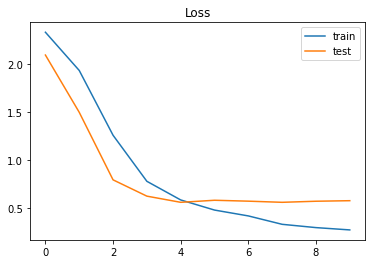

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

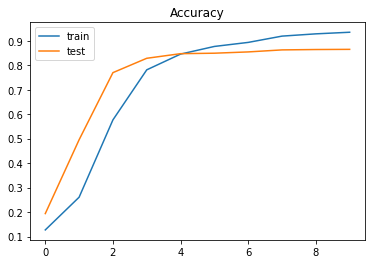

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
file_path2 = "/content/drive/MyDrive/best_model/model_best_val.h5"

file_path2 = "/content/drive/MyDrive/best_model/model_best_val.h5"
model.save(file_path)
reconstructed_model = keras.models.load_model(file_path)

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(file_path2)

In [ ]:
reconstructed_model

### Evaluating the model and make predictions

In [ ]:
# First we create an evaluation function to output all the needs metrics

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [ ]:
test_texts = validation_padded
test_labels = validation_labels

### Make Predictions

In [ ]:
eval = model.evaluate(test_texts, test_labels)

594/594 [==============================] - 4s 6ms/step - loss: 0.5614 - accuracy: 0.8486


In [ ]:
print('Loss: ', eval[0])
print('Accuracy: ', eval[1])

Loss:  0.5614392757415771
Accuracy:  0.848578929901123


In [ ]:
# Now we make predictions using the test data to see how the model performs

#predicted = reconstructed_model.predict(validation_padded)

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 86.38%
Precision: 0.86
Recall: 0.86
F1 score: 0.86


{'accuracy': 0.86, 'f1': 0.86, 'precision': 0.86, 'recall': 0.86}

### Test Model

In [ ]:
import string

In [ ]:
def clean_text(text, remove_sw=True):
    # Text to lower index
    text = text.lower()

    # Remove punkruation and numbers from the text
    remove_punkt_digets = ''
    for char in text:
        if char not in string.punctuation and not char.isdigit():
            remove_punkt_digets += char
        else:
            remove_punkt_digets += ' '

    # Remove multiple spaces from the text
    text = re.sub(r'\s+', ' ', remove_punkt_digets, flags=re.I)

    # Remove stopwords from the text (optional)
    if remove_sw:
        clean_text = ''
        tokens = word_tokenize(text)  # tokenize text string
        for token in tokens:
            if token not in russian_stopwords and token != ' ':
                clean_text = clean_text + ' ' + token
        text = clean_text.strip()
    
    return text

In [ ]:
clean_paper = clean_text(df_res['text'][56373])

In [ ]:
clean_paper

'крупнейший немецкий страховщик allianz ag договорился выкупе миллионов долларов всей доли афк система российском страховщике росно компании сообщили своем пресс релизе allianz владеет примерно процентами акций росно система продолжит свое участие страховщике владея примерно тремя процентами акций стоит отметить ранее сама афк система предлагала приобрести allianz компанию однако германский концерн заявил хотел выкупить долю системы сми также сообщали allianz предлагала контрольный пакет акций росно миллионов долларов однако глава афк система владимир евтушенков посчитал бумаги стоят миллиарда долларов группа росно году собрала страховые премии миллионов долларов росно имеет дочерние компании россии украине основными владельцами росно являются афк система владеет процентами акций немецкий allianz владеет процентами акций'

In [ ]:
seq = tokenizer.texts_to_sequences([clean_paper])
padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')

pred = model.predict(padded)

predicted_label = encode.inverse_transform(pred) 

print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')

Product category id: 9
Predicted label is: ['Экономика']


In [ ]:
encode.categories_

[array(['Бывший СССР', 'Из жизни', 'Интернет и СМИ', 'Культура', 'Мир',
        'Наука и техника', 'Россия', 'Силовые структуры', 'Спорт',
        'Экономика'], dtype=object)]

In [ ]:
df_res['text'][96373]

'Директор Государственного музея изобразительных искусств имени Пушкина Ирина Антонова названа лауреатом за 2000 год премии имени Шостаковича, учрежденной  Международным благотворительным фондом Юрия Башмета в 1994 году. Премия  вручается раз в год одному человеку за выдающиеся достижения в области искусства на  протяжении всей жизни. До сих пор ее лауреатами становились исключительно музыканты: скрипачи Гидон Кремер и Анна-Софи Муттер, виолончелистка Наталия Гутман, вокалисты  Томас Квастхофф (бас-баритон) и Ольга Бородина (меццо-сопрано), дирижер, художественный руководитель Мариинского театра  Валерий Гергиев. Церемония вручения премии имени Шостаковича Ирине Антоновой состоится 14 мая. Денежное наполнение премии составляет 25 тысяч долларов. Это самая большая из российских "культурных" премий.'

In [ ]:
df_res['topic'][96373]

'Культура'

In [ ]:
df_res

,text,topic,text_prep,text_sw,text_stem
0,Как стало известно агентству Ассошиэйтед Пресс...,Россия,как стало известно агентству ассошиэйтед пресс...,стало известно агентству ассошиэйтед пресс эки...,стал известн агентств ассошиэйтед пресс экипаж...
1,В зале игровых автоматов в третьем ярусе подзе...,Россия,в зале игровых автоматов в третьем ярусе подзе...,зале игровых автоматов третьем ярусе подземног...,зал игров автомат трет ярус подземн комплекс о...
2,Япония приняла решение разморозить кредиты Рос...,Россия,япония приняла решение разморозить кредиты рос...,япония приняла решение разморозить кредиты рос...,япон приня решен размороз кредит росс сумм пол...
3,В понедельник директор департамента внешних св...,Россия,в понедельник директор департамента внешних св...,понедельник директор департамента внешних связ...,понедельник директор департамент внешн связ ме...
4,С 1 сентября на всей территории России вводитс...,Россия,с сентября на всей территории россии вводится ...,сентября всей территории россии вводится новая...,сентябр все территор росс ввод нов форм таможе...
...,...,...,...,...,...
189994,Во временном правительстве Киргизии отвергли п...,Бывший СССР,во временном правительстве киргизии отвергли п...,временном правительстве киргизии отвергли пред...,времен правительств киргиз отвергл предложен п...
189995,"Младший сын президента Киргизии Максим Бакиев,...",Бывший СССР,младший сын президента киргизии максим бакиев ...,младший сын президента киргизии максим бакиев ...,младш сын президент киргиз макс бак котор пере...
189996,"Сотрудники украинской газеты ""Экспресс"" перекр...",Бывший СССР,сотрудники украинской газеты экспресс перекрыл...,сотрудники украинской газеты экспресс перекрыл...,сотрудник украинск газет экспресс перекр район...
189997,Бывший премьер-министр Украины Юлия Тимошенко ...,Бывший СССР,бывший премьер министр украины юлия тимошенко ...,бывший премьер министр украины юлия тимошенко ...,бывш премьер министр украин юл тимошенк объяв ...
